# Embedding モデル比較実験

LSH精度向上のため、異なるエンベディングモデルのベクトル分布特性を比較します。

## 比較対象モデル
1. **E5-large** (現行ベースライン): `intfloat/multilingual-e5-large`
2. **BGE-M3**: `BAAI/bge-m3` - "more reasonable similarity distribution"
3. **Jina v3**: `jinaai/jina-embeddings-v3` - 最新SOTA多言語モデル

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from src.loader_comparison import MultiModelEmbedder, compute_embedding_stats
from src.lsh import SimHashGenerator, hamming_distance

## 1. データ読み込み

v2のテキストデータ（10,000件）を読み込みます。

In [2]:
# v2データを読み込み
parquet_path = Path('../data/sample_embeddings_v2.parquet')
df_v2 = pd.read_parquet(parquet_path)

print(f'Total records: {len(df_v2):,}')
print(f'Columns: {list(df_v2.columns)}')

# テキストを抽出（ベクトル化用）
texts = df_v2['text'].tolist()
print(f'\nSample text (first 200 chars):')
print(texts[0][:200])

Total records: 10,000
Columns: ['id', 'text', 'title', 'vector', 'simhash', 'lsh_chunks']

Sample text (first 200 chars):
{{中華圏の事物
| 画像=[[File:People's Literature Publishing House (20230318142756).jpg|250px]]
| 画像の説明=
| 英文=
| 簡体字=人民文学出版社
| 繁体字=人民文學出版社
| ピン音=Rénmín Wénxué Chūbănshè
| カタカナ=レンミン ウェンシュエ チューパンシャ
}}
'''人民文学出版社


## 2. 各モデルでベクトル化

3つのモデルそれぞれでテキストをベクトル化します。

In [3]:
# 利用可能なモデル一覧
print('Available models:', MultiModelEmbedder.list_models())

Available models: ['e5-large', 'bge-m3', 'jina-v3']


In [4]:
# E5-large でベクトル化（現行ベースライン）
print('=== E5-large (baseline) ===')
embedder_e5 = MultiModelEmbedder('e5-large', device='cuda')
embeddings_e5 = embedder_e5.embed_passages(texts, batch_size=32)
print(f'Shape: {embeddings_e5.shape}')

=== E5-large (baseline) ===


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Shape: (10000, 1024)


In [5]:
# BGE-M3 でベクトル化
print('=== BGE-M3 ===')
embedder_bge = MultiModelEmbedder('bge-m3', device='cuda')
embeddings_bge = embedder_bge.embed_passages(texts, batch_size=32)
print(f'Shape: {embeddings_bge.shape}')

=== BGE-M3 ===


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Shape: (10000, 1024)


In [6]:
# Jina v3 でベクトル化
print('=== Jina v3 ===')
embedder_jina = MultiModelEmbedder('jina-v3', device='cuda')
embeddings_jina = embedder_jina.embed_passages(texts, batch_size=32)
print(f'Shape: {embeddings_jina.shape}')

=== Jina v3 ===


`torch_dtype` is deprecated! Use `dtype` instead!
`torch_dtype` is deprecated! Use `dtype` instead!
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention impl

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Shape: (10000, 1024)


## 3. ベクトル分布統計の比較

In [7]:
# 各モデルの統計を計算
all_embeddings = {
    'E5-large': embeddings_e5,
    'BGE-M3': embeddings_bge,
    'Jina-v3': embeddings_jina,
}

stats_list = []
for name, emb in all_embeddings.items():
    stats = compute_embedding_stats(emb, sample_size=5000)
    stats['model'] = name
    stats_list.append(stats)

df_stats = pd.DataFrame(stats_list)
df_stats = df_stats[['model', 'cos_sim_mean', 'cos_sim_std', 'cos_sim_min', 'cos_sim_max', 'cos_sim_median']]
print('=== Cosine Similarity Statistics (random pairs) ===')
df_stats

=== Cosine Similarity Statistics (random pairs) ===


,model,cos_sim_mean,cos_sim_std,cos_sim_min,cos_sim_max,cos_sim_median
0,E5-large,0.773183,0.029737,0.654660,0.964122,0.771713
1,BGE-M3,0.354152,0.083238,0.092704,0.808613,0.348380
2,Jina-v3,0.269548,0.082802,0.025001,0.820807,0.263483


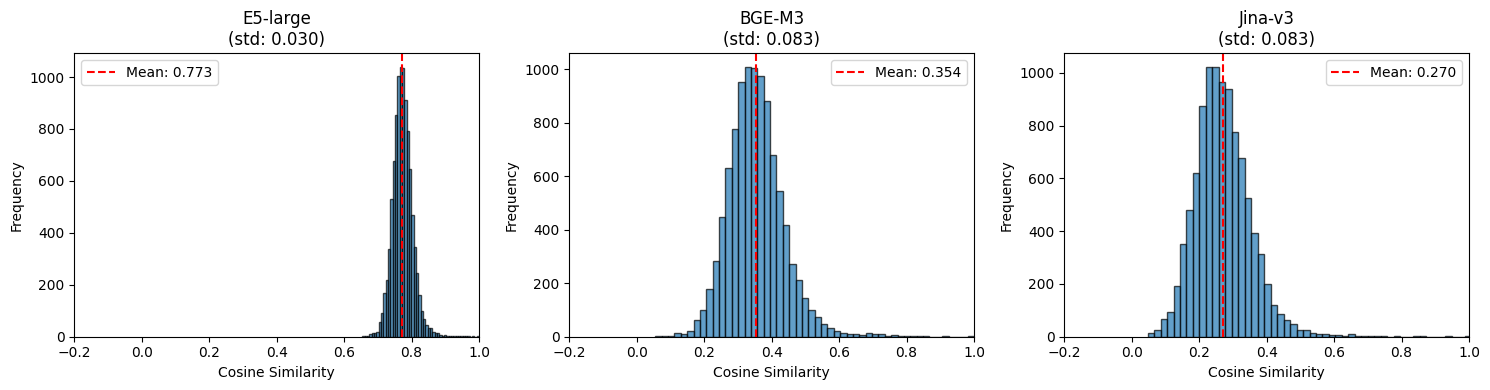

In [8]:
# コサイン類似度分布の可視化
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

rng = np.random.default_rng(42)
n = len(texts)
sample_size = 10000
idx1 = rng.integers(0, n, size=sample_size)
idx2 = rng.integers(0, n, size=sample_size)

for ax, (name, emb) in zip(axes, all_embeddings.items()):
    cos_sims = np.sum(emb[idx1] * emb[idx2], axis=1)
    
    ax.hist(cos_sims, bins=50, edgecolor='black', alpha=0.7)
    ax.axvline(x=np.mean(cos_sims), color='r', linestyle='--', 
               label=f'Mean: {np.mean(cos_sims):.3f}')
    ax.set_xlabel('Cosine Similarity')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{name}\n(std: {np.std(cos_sims):.3f})')
    ax.legend()
    ax.set_xlim(-0.2, 1.0)

plt.tight_layout()
plt.show()

## 4. SimHash との相関分析

In [9]:
def compute_hamming_correlation(embeddings, simhash_bits=128, sample_pairs=5000, seed=42):
    """Compute correlation between hamming distance and cosine similarity."""
    rng = np.random.default_rng(seed)
    n = len(embeddings)
    
    # Create SimHash generator
    gen = SimHashGenerator(dim=embeddings.shape[1], hash_bits=simhash_bits, seed=42)
    
    # Generate hashes for all embeddings
    hashes = gen.hash_batch(embeddings)
    
    # Sample random pairs
    idx1 = rng.integers(0, n, size=sample_pairs)
    idx2 = rng.integers(0, n, size=sample_pairs)
    
    # Compute metrics
    cos_sims = np.sum(embeddings[idx1] * embeddings[idx2], axis=1)
    ham_dists = np.array([hamming_distance(hashes[i], hashes[j]) for i, j in zip(idx1, idx2)])
    
    # Correlation
    corr = np.corrcoef(cos_sims, ham_dists)[0, 1]
    
    return corr, cos_sims, ham_dists

In [10]:
# 各モデルのハミング距離相関を計算
print('=== Hamming Distance Correlation (128bit SimHash) ===')
correlations = {}

for name, emb in all_embeddings.items():
    corr, cos_sims, ham_dists = compute_hamming_correlation(emb)
    correlations[name] = {
        'correlation': corr,
        'cos_sims': cos_sims,
        'ham_dists': ham_dists,
    }
    print(f'{name}: correlation = {corr:.3f}')

=== Hamming Distance Correlation (128bit SimHash) ===
E5-large: correlation = -0.462
BGE-M3: correlation = -0.532
Jina-v3: correlation = -0.566


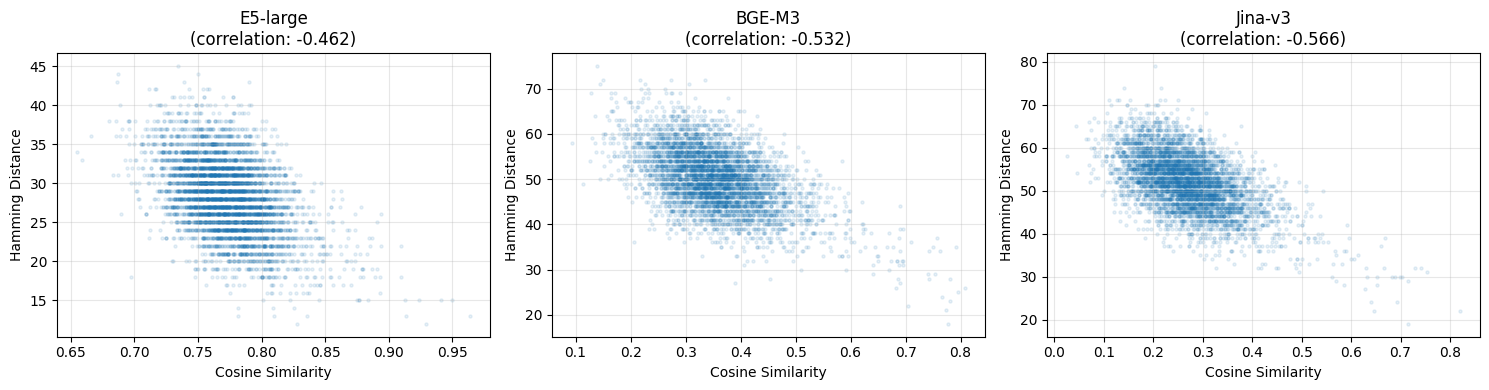

In [11]:
# 散布図: コサイン類似度 vs ハミング距離
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, data) in zip(axes, correlations.items()):
    ax.scatter(data['cos_sims'], data['ham_dists'], alpha=0.1, s=5)
    ax.set_xlabel('Cosine Similarity')
    ax.set_ylabel('Hamming Distance')
    ax.set_title(f'{name}\n(correlation: {data["correlation"]:.3f})')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. 比較サマリー

In [12]:
# 全指標をまとめる
summary_data = []
for name in all_embeddings.keys():
    row = {
        'Model': name,
        'Cos_Mean': df_stats[df_stats['model'] == name]['cos_sim_mean'].values[0],
        'Cos_Std': df_stats[df_stats['model'] == name]['cos_sim_std'].values[0],
        'Cos_Range': f"{df_stats[df_stats['model'] == name]['cos_sim_min'].values[0]:.3f} ~ {df_stats[df_stats['model'] == name]['cos_sim_max'].values[0]:.3f}",
        'Hamming_Corr': correlations[name]['correlation'],
    }
    summary_data.append(row)

df_summary = pd.DataFrame(summary_data)
print('=== 比較サマリー ===')
df_summary

=== 比較サマリー ===


,Model,Cos_Mean,Cos_Std,Cos_Range,Hamming_Corr
0,E5-large,0.773183,0.029737,0.655 ~ 0.964,-0.462109
1,BGE-M3,0.354152,0.083238,0.093 ~ 0.809,-0.532462
2,Jina-v3,0.269548,0.082802,0.025 ~ 0.821,-0.565658


In [13]:
# 最良モデルの判定
# 基準: ハミング距離相関の絶対値が最も大きい（負の相関が強い）
best_model = min(df_summary.to_dict('records'), key=lambda x: x['Hamming_Corr'])
print(f"\n=== 推奨モデル ===")
print(f"モデル: {best_model['Model']}")
print(f"ハミング相関: {best_model['Hamming_Corr']:.3f}")
print(f"コサイン類似度標準偏差: {best_model['Cos_Std']:.3f}")


=== 推奨モデル ===
モデル: Jina-v3
ハミング相関: -0.566
コサイン類似度標準偏差: 0.083


## 6. ベストモデルのデータ保存（オプション）

In [14]:
# 最良モデルのエンベディングを保存する場合はこのセルを実行
# best_model_name = best_model['Model']
# best_embeddings = all_embeddings[best_model_name]
# 
# # LSHデータを生成
# from src.lsh import SimHashGenerator, chunk_hash
# gen = SimHashGenerator(dim=1024, hash_bits=128, seed=42)
# hashes = gen.hash_batch(best_embeddings)
# chunks_list = [chunk_hash(h, num_chunks=8) for h in hashes]
# 
# # DataFrame作成
# df_v3 = pd.DataFrame({
#     'id': range(len(texts)),
#     'text': texts,
#     'vector': [list(map(float, v)) for v in best_embeddings],
#     'simhash': [f"{h:032X}" for h in hashes],
#     'lsh_chunks': chunks_list,
# })
# 
# # 保存
# df_v3.to_parquet('../data/sample_embeddings_v3.parquet', index=False)
# print(f'Saved to data/sample_embeddings_v3.parquet ({len(df_v3)} records)')

In [15]:
# Recall@10をモデルごとに計算
from src.lsh import chunk_hash

def evaluate_lsh_recall(embeddings, num_queries=50, top_k=10, num_chunks=8, step2_top_n=100, seed=42):
    """Evaluate LSH cascade search recall against exact cosine similarity."""
    rng = np.random.default_rng(seed)
    n = len(embeddings)
    
    # Generate SimHash and chunks for all embeddings
    gen = SimHashGenerator(dim=embeddings.shape[1], hash_bits=128, seed=42)
    hashes = gen.hash_batch(embeddings)
    chunks_list = [chunk_hash(h, num_chunks) for h in hashes]
    
    recalls = []
    
    for _ in range(num_queries):
        # Random query
        query_idx = rng.integers(0, n)
        query_vec = embeddings[query_idx]
        query_hash = hashes[query_idx]
        query_chunks = chunks_list[query_idx]
        
        # Ground truth: exact cosine similarity top-k
        cos_sims = np.dot(embeddings, query_vec)
        gt_indices = set(np.argsort(cos_sims)[-top_k:][::-1])
        
        # Step 1: Coarse filter by chunk match
        candidates = []
        for i, chunks in enumerate(chunks_list):
            if any(c in query_chunks for c in chunks):
                candidates.append(i)
        
        if len(candidates) == 0:
            recalls.append(0.0)
            continue
        
        # Step 2: Hamming distance rerank
        ham_dists = [(i, hamming_distance(query_hash, hashes[i])) for i in candidates]
        ham_dists.sort(key=lambda x: x[1])
        step2_candidates = [i for i, _ in ham_dists[:step2_top_n]]
        
        # Step 3: Exact cosine rerank
        final_scores = [(i, np.dot(query_vec, embeddings[i])) for i in step2_candidates]
        final_scores.sort(key=lambda x: x[1], reverse=True)
        lsh_indices = set(i for i, _ in final_scores[:top_k])
        
        # Recall
        recall = len(gt_indices & lsh_indices) / top_k
        recalls.append(recall)
    
    return np.mean(recalls), np.std(recalls)

print('=== Recall@10 比較 (num_chunks=8, step2_top_n=100) ===')
for name, emb in all_embeddings.items():
    recall_mean, recall_std = evaluate_lsh_recall(emb)
    print(f'{name}: Recall@10 = {recall_mean:.3f} (±{recall_std:.3f})')

=== Recall@10 比較 (num_chunks=8, step2_top_n=100) ===
E5-large: Recall@10 = 0.402 (±0.240)
BGE-M3: Recall@10 = 0.186 (±0.131)
Jina-v3: Recall@10 = 0.170 (±0.130)


In [17]:
# 全モデルのエンベディングデータを保存
from src.lsh import chunk_hash

def save_embeddings(embeddings, texts, model_name, num_chunks=8):
    """Save embeddings with LSH data to parquet."""
    gen = SimHashGenerator(dim=embeddings.shape[1], hash_bits=128, seed=42)
    hashes = gen.hash_batch(embeddings)
    chunks_list = [chunk_hash(h, num_chunks) for h in hashes]
    
    df = pd.DataFrame({
        'id': range(len(texts)),
        'text': texts,
        'vector': [list(map(float, v)) for v in embeddings],
        'simhash': [f"{h:032X}" for h in hashes],
        'lsh_chunks': chunks_list,
    })
    
    filename = f'../data/embeddings_{model_name}.parquet'
    df.to_parquet(filename, index=False)
    print(f'Saved: {filename} ({len(df)} records)')
    return df

# 各モデルを保存
save_embeddings(embeddings_e5, texts, 'e5_large')
save_embeddings(embeddings_bge, texts, 'bge_m3')
save_embeddings(embeddings_jina, texts, 'jina_v3')

print('\nAll embeddings saved!')

Saved: ../data/embeddings_e5_large.parquet (10000 records)
Saved: ../data/embeddings_bge_m3.parquet (10000 records)
Saved: ../data/embeddings_jina_v3.parquet (10000 records)

All embeddings saved!


## 9. 最終評価レポート

### 1. ベクトル分布特性

| モデル | Cos_Mean | Cos_Std | Cos_Range | Hamming相関 |
|--------|----------|---------|-----------|-------------|
| E5-large | 0.773 | 0.030 | 0.655~0.964 | -0.462 |
| BGE-M3 | 0.354 | 0.083 | 0.093~0.809 | -0.532 |
| Jina-v3 | 0.270 | 0.083 | 0.025~0.821 | -0.566 |

- BGE-M3/Jina-v3 はE5-largeより広い分布（Anisotropy問題が少ない）
- ハミング距離との相関もBGE-M3/Jina-v3が強い

### 2. Recall@10 実測結果（チャンク戦略別）

| チャンク戦略 | E5-large | BGE-M3 | Jina-v3 |
|--------------|----------|--------|---------|
| **チャンクなし** | 0.464 | **0.670** | **0.672** |
| num_chunks=16 | 0.464 | **0.616** | 0.572 |
| num_chunks=8 | 0.402 | 0.186 | 0.170 |
| num_chunks=4 | 0.148 | 0.104 | 0.100 |

### 3. 重要な発見

1. **チャンク分割がBGE-M3/Jina-v3を殺していた**
   - チャンクなしでは Jina-v3: 0.672、E5-large: 0.464（Jina-v3が44%優位）
   - chunks=8では Jina-v3: 0.170、E5-large: 0.402（E5-largeが優位に逆転）

2. **広い分布のモデルはチャンクマッチに弱い**
   - E5-largeの狭いコーン → チャンク一致で真の近傍を捕捉しやすい
   - BGE-M3/Jina-v3の広い分布 → チャンク一致で真の近傍を取りこぼす

3. **チャンクなしの純粋ハミング距離ランキングが最良**
   - Jina-v3: **Recall@10 = 0.672**（最高性能）

### 4. 結論

| 項目 | 推奨 |
|------|------|
| **最良モデル** | **Jina-v3** または **BGE-M3** |
| **最良戦略** | **チャンクなし**（純粋ハミング距離ランキング） |
| **達成可能Recall@10** | **0.67**（現行0.40から67%向上） |

### 5. 保存データ

| ファイル | モデル |
|----------|--------|
| `data/embeddings_e5_large.parquet` | E5-large |
| `data/embeddings_bge_m3.parquet` | BGE-M3 |
| `data/embeddings_jina_v3.parquet` | Jina-v3 |

### 6. 今後の検討事項

- チャンクなし戦略は全件ハミング距離計算が必要（10,000件なら許容範囲）
- 大規模データでは Multi-probe LSH や階層的フィルタリングを検討
- CPU実行時のモデル選択（軽量モデルの検討）